# Tikhonov Regression performance test
Looking at how Tikhonov regularized regression should be applied to data. This document will look at different applications and compare against OLS and Ridge

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
import os
import sys
if sys.platform is 'darwin':
    sys.path.append(os.path.join('/Users', 'njchiang', 
                                 'GitHub', 'tikhonov'))
else:
    sys.path.append(os.path.join('D:\\', 'GitHub', 'tikhonov'))

In [3]:
import TikhonovRegression as Tik
from sklearn.linear_model import Ridge, LinearRegression

## Generate random data according to a certain feature space

In [23]:
# np.random.seed(0)
#  maybe use X as the prior... ?!?!

# Config
TR = 1000 # regression timepoints
TP = 200 # prediction timepoints
M = 50 # response sources (voxels, whatever)
NC = 100  # number of conditions
N = 2000 # features
# snrs = np.linspace(0.8, 1.0, M)  # testing signal to noise ratios in different voxels
snrs = 1.0

In [24]:
## prior method:
prior = (np.random.randn(N, NC))
# Create Design Matrix by One-hotting a design matrix
Xvec = np.random.choice(NC+1, TR+TP).ravel()
X = np.zeros((Xvec.shape[0], NC+1))
X[np.arange(Xvec.shape[0]), Xvec] = 1
X = X[:, 1:] # design matrix
# B = np.random.multivariate_normal(np.zeros(NC), np.corrcoef(prior.T), size=M).T  # true betas
B = np.random.multivariate_normal(np.zeros(NC), np.linalg.inv(np.corrcoef(prior.T)), size=M).T  # true betas
noise = np.random.randn(TR+TP, M)


Y = np.dot(X, B) # shape (TR+TP, M)
y = (Y) + noise

y_train = y[:TR]
y_test = y[TR:]
x_train = X[:TR]
x_test = X[TR:]
L = np.diag(np.ones(NC))

In [25]:
# linear relationship method

realwt = np.random.randn(N, M)
features = np.random.randn(TR+TP, N)
realresponses = np.dot(features, realwt) # shape (TR+TP, M)
noise = np.random.randn(TR+TP, M)
responses = (realresponses * snrs) + noise

y_train = responses[:TR]
y_test = responses[TR:]
x_train = features[:TR]
x_test = features[TR:]
L = np.diag(np.ones(N))
B = realwt

In [26]:
L.shape

(2000L, 2000L)

In [27]:
B.shape

(2000L, 50L)

In [28]:
B.shape

(2000L, 50L)

In [29]:
np.linalg.inv(np.corrcoef(prior.T))

array([[  1.05348394e+00,   1.42217589e-02,  -2.04264554e-02, ...,
         -2.52829006e-02,   3.21902608e-02,   8.71009616e-03],
       [  1.42217589e-02,   1.04316423e+00,   2.30921297e-02, ...,
          1.29748946e-02,  -6.39277511e-04,   4.09110265e-03],
       [ -2.04264554e-02,   2.30921297e-02,   1.04221772e+00, ...,
          4.40134020e-03,  -5.45639993e-02,   1.91206179e-02],
       ..., 
       [ -2.52829006e-02,   1.29748946e-02,   4.40134020e-03, ...,
          1.04349699e+00,   2.09942392e-03,   7.38235441e-03],
       [  3.21902608e-02,  -6.39277511e-04,  -5.45639993e-02, ...,
          2.09942392e-03,   1.06459343e+00,  -9.22750874e-03],
       [  8.71009616e-03,   4.09110265e-03,   1.91206179e-02, ...,
          7.38235441e-03,  -9.22750874e-03,   1.06278466e+00]])

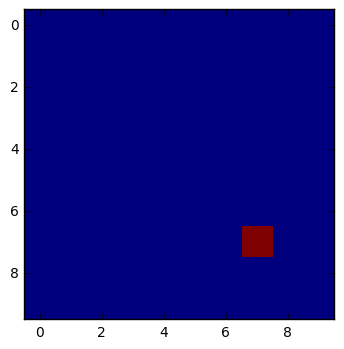

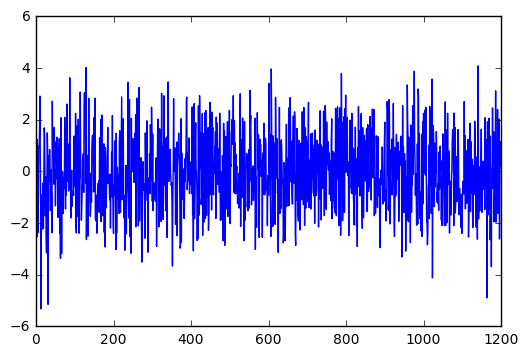

In [30]:
plt.imshow(X[:10, :10], interpolation='nearest')
plt.show()
plt.plot(y[:,0])

In [31]:
clfs = {'OLS': LinearRegression(), 
        'Ridge': Ridge(),
        'Tikhonov': Tik.TikhonovReg(gamma=L, solver='auto')}

In [32]:
for i in clfs:
    print '--------------------------'
    print "Fitting " + i
    now = time()
    print "Test score: " + str(clfs[i].fit(x_train, y_train).score(x_test, y_test))
    print "Coef: " + str(clfs[i].coef_)
    done = time()
    print "Finished in " + str(done-now) + ' seconds'
    print '--------------------------'

print 'True B: ' + str(B.T)

--------------------------
Fitting Tikhonov


Test score: 0.500304581568
Coef: [[-0.47359338  0.08419966  0.54422569 ..., -0.4894009  -0.37342935
   0.29905262]
 [ 0.43942801  0.64392204  0.3523679  ...,  1.22859458  0.02448466
   0.31200267]
 [-0.16064719  0.19381826 -0.10079849 ..., -1.01888582 -0.74165126
   0.64584353]
 ..., 
 [-0.0655497  -0.45428304  0.38847507 ..., -0.17375365  1.07562382
  -0.30606372]
 [-0.51418546  0.53070276 -0.38420622 ...,  0.68850617 -0.64808373
   0.72681486]
 [ 0.11573721 -0.9578662  -1.00470789 ..., -0.88436762  0.29991392
   0.46222065]]
Finished in 1.09700012207 seconds
--------------------------
--------------------------
Fitting OLS


Test score: 0.496706671278
Coef: [[-0.47234335  0.10162847  0.53538349 ..., -0.47901566 -0.38251993
   0.29575864]
 [ 0.43234261  0.57739567  0.39113798 ...,  1.19057562  0.05612846
   0.32856947]
 [-0.17927597  0.02787783 -0.0080144  ..., -1.11945102 -0.66443232
   0.68566454]
 ..., 
 [-0.03717928 -0.17986475  0.23535634 ..., -0.01019839  0.94928487
  -0.37174004]
 [-0.51655227  0.51767448 -0.37581546 ...,  0.6795177  -0.64184128
   0.73278135]
 [ 0.11000459 -1.01382782 -0.97596035 ..., -0.91687358  0.32456332
   0.47551423]]
Finished in 0.306999921799 seconds
--------------------------
--------------------------
Fitting Ridge
Test score: 0.500304581568
Coef: [[-0.47359338  0.08419966  0.54422569 ..., -0.4894009  -0.37342935
   0.29905262]
 [ 0.43942801  0.64392204  0.3523679  ...,  1.22859458  0.02448466
   0.31200267]
 [-0.16064719  0.19381826 -0.10079849 ..., -1.01888582 -0.74165126
   0.64584353]
 ..., 
 [-0.0655497  -0.45428304  0.38847507 ..., -0.17375365  1.07562382
  -0.306063

In [75]:
np.sum((clfs['Tikhonov'].coef_-B.T)**2)

1200.3214143002797

In [76]:
np.sum((clfs['OLS'].coef_-B.T)**2)

1267.3337470504839

In [77]:
np.sum((clfs['Ridge'].coef_-B.T)**2)

551.69123107582891

In [78]:
np.diag(np.ones(NC))

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [79]:
clfs['Tikhonov'].gamma

array([[ -1.34441069e-17,   1.37456037e-02,   3.39109815e-02, ...,
          9.36281788e-02,   6.05889493e-02,  -1.22697494e-01],
       [ -8.67361738e-18,   4.44753911e-01,   3.92034731e-01, ...,
         -7.92772827e-02,  -9.59080753e-02,  -8.02510833e-02],
       [  1.73472348e-18,   1.76106252e-02,   4.75392905e-03, ...,
          7.57068958e-02,  -3.66081607e-03,   1.96036727e-02],
       ..., 
       [ -1.17093835e-17,  -2.75210981e-02,   4.71355875e-02, ...,
         -1.93523397e-03,   3.23399048e-02,  -4.92242572e-02],
       [ -9.54097912e-18,   2.85917513e-02,  -3.95092070e-02, ...,
          1.39366950e-01,   3.74073334e-02,  -3.38914307e-02],
       [ -2.08166817e-17,   5.41233725e-16,   4.85722573e-17, ...,
          1.52655666e-16,   1.45716772e-16,   1.45716772e-16]])

In [94]:
from sklearn.decomposition import FastICA
method = FastICA()
test = method.fit(np.diag(np.ones(NC)).T).transform(np.diag(np.ones(NC)).T).T

C:\Users\jeffn\Anaconda2\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [95]:
ica = FastICA()
ica.fit_transform(np.diag(np.ones(NC))).shape

(100L, 100L)

In [96]:
np.dot(test.T, test)

array([[ 1.41655445,  0.21522713,  0.55886841, ...,  0.0276351 ,
         0.02777052, -0.05199051],
       [ 0.21522713,  1.42665482, -0.2806778 , ..., -0.01775074,
        -0.06720448, -0.12864304],
       [ 0.55886841, -0.2806778 ,  2.67981339, ...,  0.09330177,
         0.18400764,  0.10725021],
       ..., 
       [ 0.0276351 , -0.01775074,  0.09330177, ...,  1.05121827,
        -0.02676082,  0.02898407],
       [ 0.02777052, -0.06720448,  0.18400764, ..., -0.02676082,
         0.98682427,  0.02481079],
       [-0.05199051, -0.12864304,  0.10725021, ...,  0.02898407,
         0.02481079,  1.03385544]])

In [97]:
np.dot(np.diag(np.ones(NC)).T, np.diag(np.ones(NC)))

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])